In [1]:
from ciao_contrib.runtool import *
from sherpa.astro.ui import *

import astropy
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

from multiprocessing import Pool
from subprocess import call
import shutil
import copy
import os

import glob
import regions as rg
import numpy as np

#import pyds9 as ds9 --- doing these manually (reformatting reg files)



## Need to convert coordinates

In [2]:
gc = SkyCoord(l=0.113*u.degree, b= -1.424*u.degree, frame='galactic')

icrs_ra = gc.icrs.ra.deg
icrs_dec = gc.icrs.dec.deg


## Find and download observations

In [3]:
os.chdir('/Volumes/backitup/MW_I')

find_chandra_obsid(arg=icrs_ra, dec=icrs_dec,radius=2.56,grating="none",download="all")

#call(['download_chandra_obsid','310']) --- or use download="all" in find_chandra_obsid


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits      103 Mb  ####################           15 s  6947.2 kb/s
  vvref    pdf        81 Mb  ####################           13 s  6223.9 kb/s
  evt2     fits       18 Mb  ####################            3 s  5717.3 kb/s
  asol     fits        9 Mb  ####################            2 s  5694.7 kb/s
  mtl      fits        2 Mb  ####################          < 1 s  6899.7 kb/s
  stat     fits        1 Mb  ####################          < 1 s  3962.1 kb/s
  aqual    fits      624 Kb  ####################          < 1 s  3396.0 kb/s
  cntr_img jpg       615 Kb  ####################          < 1 s  1880.7 kb/s
  bias     fits      497 Kb  ####################          < 1 s  3745.6 kb/s
  bias     fits      439 Kb  ####################          < 1 s  3598.4 kb/s
  bias     fits      439 Kb  ####################          < 1 

## Define the observation directories

In [2]:
target_name='MW_I'
base_dir='/Volumes/backitup/'
target_dir=base_dir+target_name+'/' 

# For each folder in the M31 folder, add those that include digits to the obsid list (so all)
obsid=[]
for i in range(len(os.listdir(target_dir))):
    if os.listdir(target_dir)[i].isdigit():
        obsid.append(os.listdir(target_dir)[i])

data_dirs=[target_dir+i+'/' for i in obsid]

primary_dirs=[i+'primary/' for i in data_dirs]

repro_dirs=[i+'repro/' for i in data_dirs]

merged_dir=target_dir+'Merged/'

spec_dir=target_dir+'Spec/'

spec2_dir=target_dir+'Spec2/'

verbose=2

print(repro_dirs)

['/Volumes/backitup/MW_I/5934/repro/', '/Volumes/backitup/MW_I/6362/repro/', '/Volumes/backitup/MW_I/6365/repro/', '/Volumes/backitup/MW_I/7162/repro/', '/Volumes/backitup/MW_I/7168/repro/', '/Volumes/backitup/MW_I/9500/repro/', '/Volumes/backitup/MW_I/9501/repro/', '/Volumes/backitup/MW_I/9502/repro/', '/Volumes/backitup/MW_I/9503/repro/', '/Volumes/backitup/MW_I/9504/repro/', '/Volumes/backitup/MW_I/9505/repro/', '/Volumes/backitup/MW_I/9854/repro/', '/Volumes/backitup/MW_I/9855/repro/', '/Volumes/backitup/MW_I/9892/repro/', '/Volumes/backitup/MW_I/9893/repro/']


## Reprocess Data

In [5]:
for i in range(len(repro_dirs)):
    chandra_repro.punlearn()
    chandra_repro.indir=data_dirs[i]
    repro_dir=repro_dirs[i]
    try:
        os.mkdir(repro_dir)
    except:
        for files in os.listdir(repro_dir):
            os.remove(repro_dir+files)        
        os.rmdir(repro_dir)
    chandra_repro.outdir=repro_dir
    a=chandra_repro()
    if verbose>=2:
        print(a)
    else:
        print('repro observation' +obsID+' of '+target_name)


Running chandra_repro
version: 22 January 2023


Processing input directory '/Volumes/backitup/MW_I/5934'

No boresight correction update to asol file is needed.
Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /Volumes/backitup/MW_I/5934/repro/acisf05934_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...
Setting observation-specific bad pixel file in local ardlib.par.

Cleaning up intermediate files

         /Volumes/backitup/MW_I/5934/repro/acisf05934_repro_bpix1.fits
         Run 'punlearn ardlib' when analysis of this dataset completed.

Any issues pertaining to data quality for this observation will be listed in the Comments section

## Filter the event files for the appropriate ccdids

In [9]:
'''find the events file and make necessary ccdid cut''' 

matching_files = []

for root, dirs, files in os.walk(target_dir):
    for file in files:
        if file.endswith(('repro_evt2.fits')):
            full_path = os.path.join(root, file)
            matching_files.append(full_path)
            
#print(matching_files)
            
cut_files = []
for evt_file in matching_files:
    ccdid_cut = '[ccd_id=0,1,2,3]'
    
    file_parts = evt_file.split('.')
    new_file_name = '.'.join(file_parts[:-1]) + '_cut.' + file_parts[-1]
    
    dmcopy.punlearn()
    dmcopy(f"{evt_file}{ccdid_cut}", new_file_name, clobber=True)
    
    cut_files.append(new_file_name)
    
    temp_dir = os.path.join(os.path.dirname(evt_file), 'temp')
    os.makedirs(temp_dir, exist_ok=True)
    call(['mv', evt_file, temp_dir])

print("Cut files:", cut_files)

Cut files: ['/Volumes/backitup/MW_I/5934/repro/acisf05934_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/6362/repro/acisf06362_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/6365/repro/acisf06365_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/7162/repro/acisf07162_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/7168/repro/acisf07168_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9500/repro/acisf09500_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9501/repro/acisf09501_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9502/repro/acisf09502_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9503/repro/acisf09503_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9504/repro/acisf09504_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9505/repro/acisf09505_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9854/repro/acisf09854_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9855/repro/acisf09855_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9892/repro/acisf09892_repro_evt2_cut.fits', '/Volumes/backitup/MW_I/9893/repro/a

## Make instrument maps

In [7]:
'''instrument map making'''
os.chdir(target_dir)

make_instmap_weights.punlearn()
make_instmap_weights(target_dir+'weight1.txt',"powlaw1d.p1"\
,paramvals="p1.gamma=1.7", emin=0.3, emax=1.5, ewidth=0.1,clobber=True)

make_instmap_weights.punlearn()
make_instmap_weights(target_dir+'weight2.txt',"powlaw1d.p1"\
,paramvals="p1.gamma=1.7", emin=1.5, emax=7.0, ewidth=0.1,clobber=True)

make_instmap_weights.punlearn()
make_instmap_weights(target_dir+'weight3.txt',"powlaw1d.p1"\
,paramvals="p1.gamma=1.7", emin=0.3, emax=7.0, ewidth=0.1,clobber=True)


 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Model used: 
powlaw1d.p1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   p1.gamma     thawed          1.7          -10           10           
   p1.ref       frozen            1 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed            1            0  3.40282e+38           
Created: /Volumes/backitup/MW_I/weight3.txt

## Merge observations

In [10]:
'''merge observations'''

merge_obs.punlearn()
merge_obs(data_dirs,merged_dir, \
          bands=target_dir+'weight1.txt,'+target_dir+'weight2.txt,'+target_dir+'weight3.txt',\
          psfecf=0.9, psfmerge='expmap',binsize=1, clobber=True)

Running merge_obs
Version: 05 November 2021

Found /Volumes/backitup/MW_I/5934/repro/acisf05934_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/6362/repro/acisf06362_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/6365/repro/acisf06365_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/7162/repro/acisf07162_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/7168/repro/acisf07168_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9500/repro/acisf09500_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9501/repro/acisf09501_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9502/repro/acisf09502_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9503/repro/acisf09503_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9504/repro/acisf09504_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9505/repro/acisf09505_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9854/repro/acisf09854_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/9855/repro/acisf09855_repro_evt2_cut.fits
Found /Volumes/backitup/MW_I/989

In [3]:
'''Set merged files for later use'''


s_count_img_merged = merged_dir+'band1_thresh.img'
s_expmap_merged = merged_dir+'band1_thresh.expmap'
s_psfmap_merged = merged_dir+'band1_thresh.psfmap'
s_flux_img_merged = merged_dir+'band1_flux.img'

h_count_img_merged = merged_dir+'band2_thresh.img'
h_expmap_merged = merged_dir+'band2_thresh.expmap'
h_psfmap_merged = merged_dir+'band2_thresh.psfmap'
h_flux_img_merged = merged_dir+'band2_flux.img'

b_count_img_merged = merged_dir+'band3_thresh.img'
b_expmap_merged = merged_dir+'band3_thresh.expmap'
b_psfmap_merged = merged_dir+'band3_thresh.psfmap'
b_flux_img_merged = merged_dir+'band3_flux.img'

s_src_reg_file= merged_dir+'band1_src_pnts.reg'
h_src_reg_file= merged_dir+'band2_src_pnts.reg'
b_src_reg_file= merged_dir+'band3_src_pnts.reg'


## Detect point sources with wavdetect

In [19]:
'''use wavdetect to detect point sources'''

s_src_reg_file= merged_dir+'band1_src_pnts.reg'
h_src_reg_file= merged_dir+'band2_src_pnts.reg'
b_src_reg_file= merged_dir+'band3_src_pnts.reg'

scales='1 2 4 8'
ellsigma="5.0"
sigthresh=1E-7

wavdetect.punlearn()
wavdetect(infile=s_count_img_merged,outfile=merged_dir+'band1_src_pnts.fits',scellfile = merged_dir+'band1_scellfile.fits',\
          imagefile = merged_dir+'band1_imagefile.fits',defnbkgfile = merged_dir+'band1_defnbkgfile.fits',\
          interdir=merged_dir,regfile=s_src_reg_file,clobber=True,scales=scales,\
          psffile=s_psfmap_merged,ellsigma=ellsigma,sigthresh=sigthresh)
wavdetect(infile=h_count_img_merged,outfile=merged_dir+'band2_src_pnts.fits',scellfile = merged_dir+'band2_scellfile.fits',\
          imagefile = merged_dir+'band2_imagefile.fits',defnbkgfile = merged_dir+'band2_defnbkgfile.fits',\
          interdir=merged_dir,regfile=h_src_reg_file,clobber=True,scales=scales,\
          psffile=s_psfmap_merged,ellsigma=ellsigma,sigthresh=sigthresh)
wavdetect(infile=b_count_img_merged,outfile=merged_dir+'band3_src_pnts.fits',scellfile = merged_dir+'band3_scellfile.fits',\
          imagefile = merged_dir+'band3_imagefile.fits',defnbkgfile = merged_dir+'band3_defnbkgfile.fits',\
          interdir=merged_dir,regfile=b_src_reg_file,clobber=True,scales=scales,\
          psffile=s_psfmap_merged,ellsigma=ellsigma,sigthresh=sigthresh)

# I end up doing the next part manually because I cant download pyds9 

# d=ds9.DS9()
# d.set('file '+s_count_img_merged)
# d.set('regions '+s_src_reg_file)
# d.set('regions system WCS')
# d.set('regions sky fk5')
# d.set('regions save '+s_src_reg_file)
# d.set('exit')

# d=ds9.DS9()
# d.set('file '+h_count_img_merged)
# d.set('regions '+h_src_reg_file)
# d.set('regions system WCS')
# d.set('regions sky fk5')
# d.set('regions save '+h_src_reg_file)
# d.set('exit')

# d=ds9.DS9()
# d.set('file '+b_count_img_merged)
# d.set('regions '+b_src_reg_file)
# d.set('regions system WCS')
# d.set('regions sky fk5')
# d.set('regions save '+b_src_reg_file)
# d.set('exit')


## Merge the detection from three bands into one region file

Set MJD-END to 54682.373229 from DATE-END'. [astropy.wcs.wcs]


detect 439 point sources from soft band image
detect 879 point sources from hard band image
detect 1038 point sources from broad band image
merged into 1137 point sources


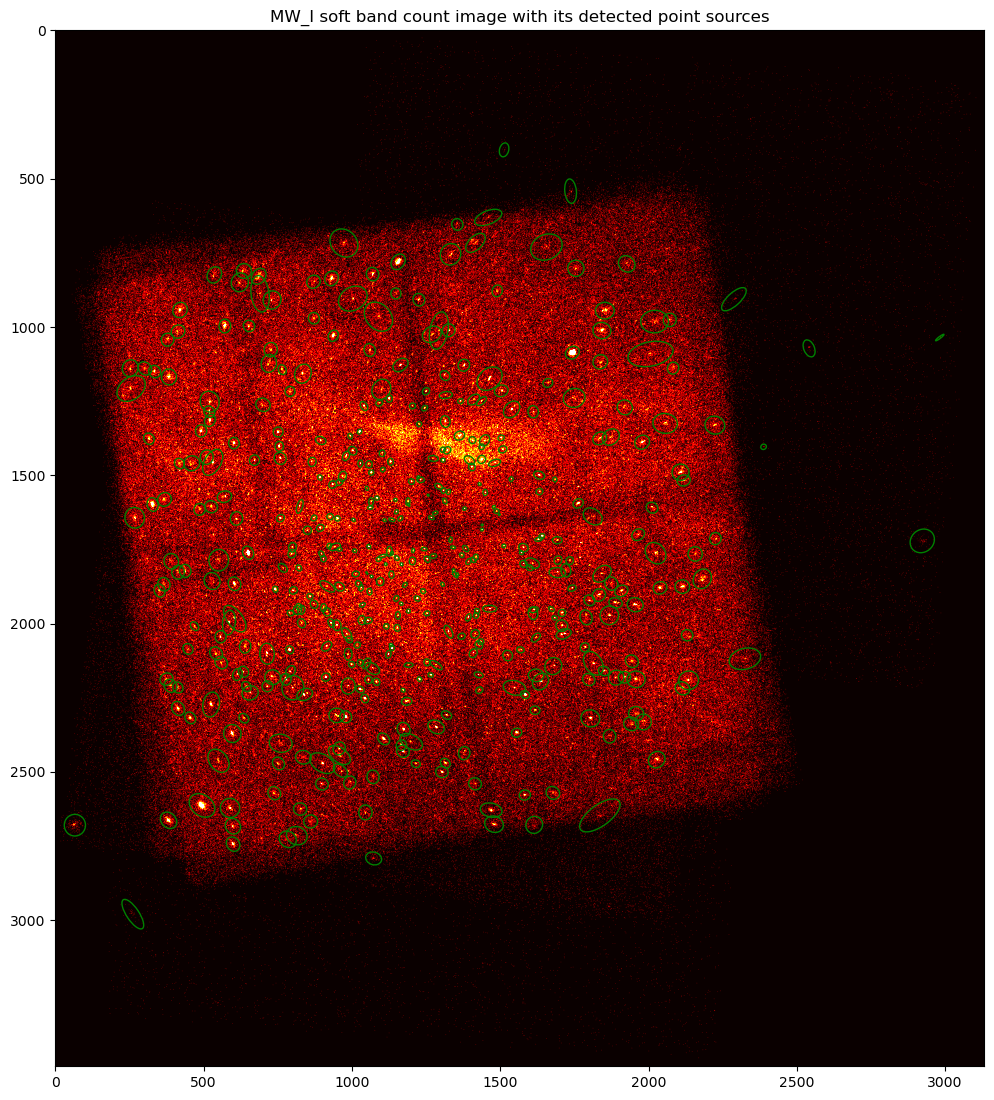

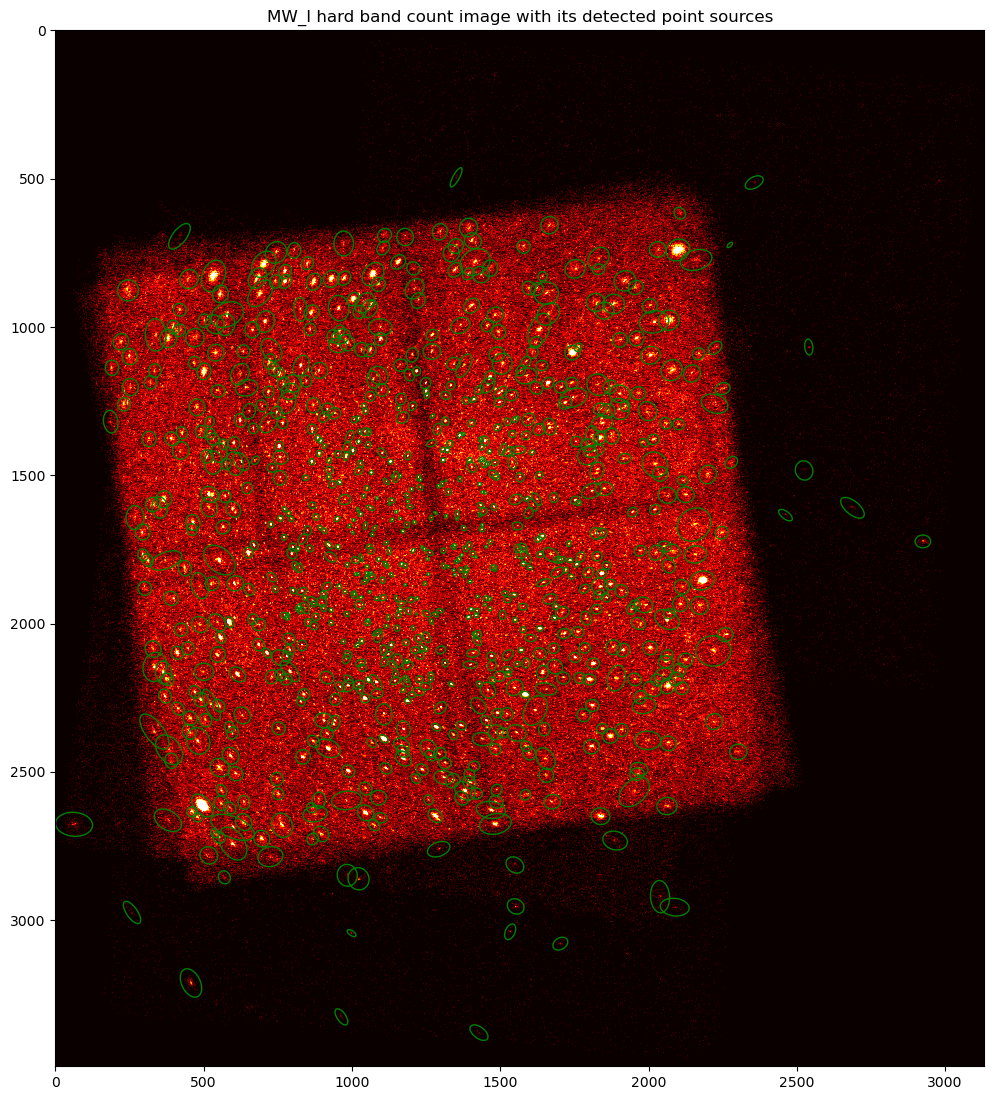

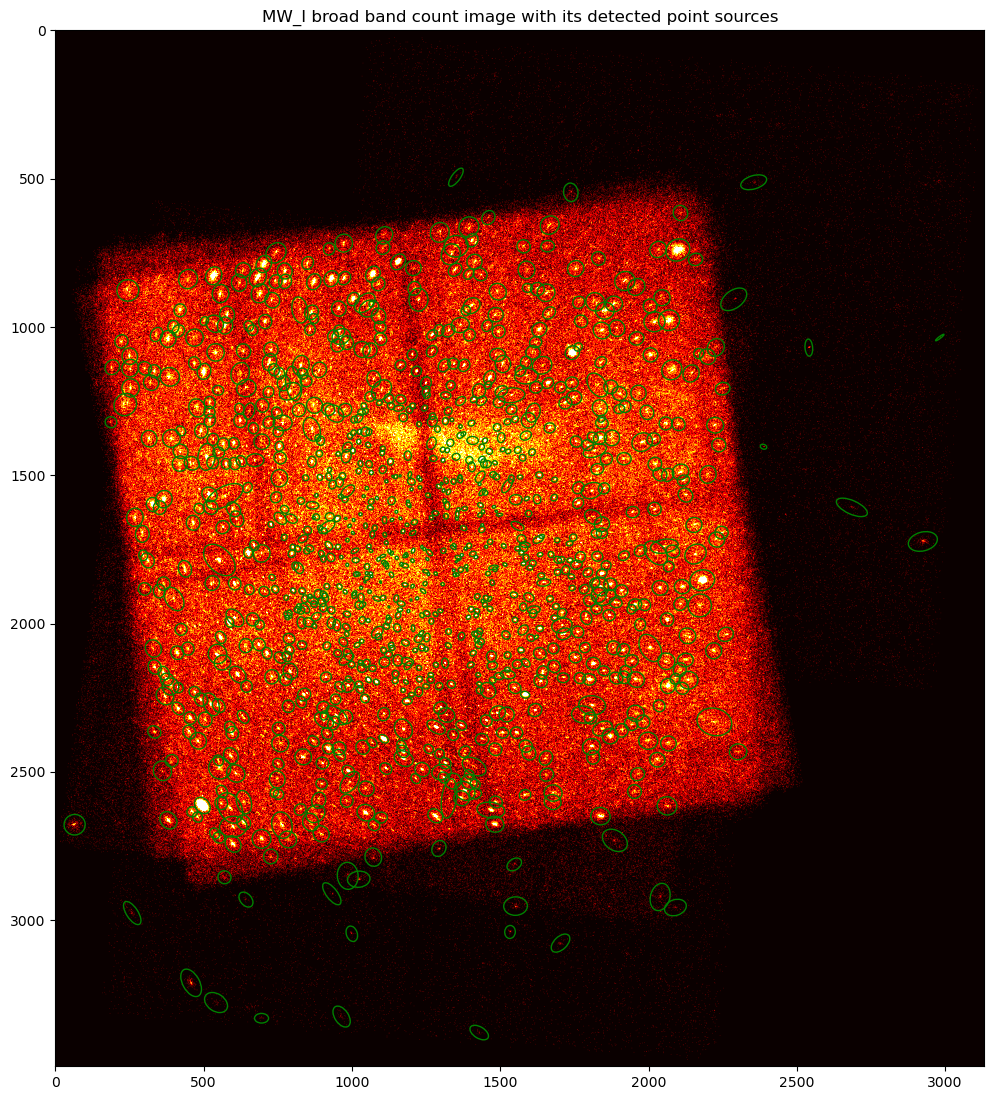

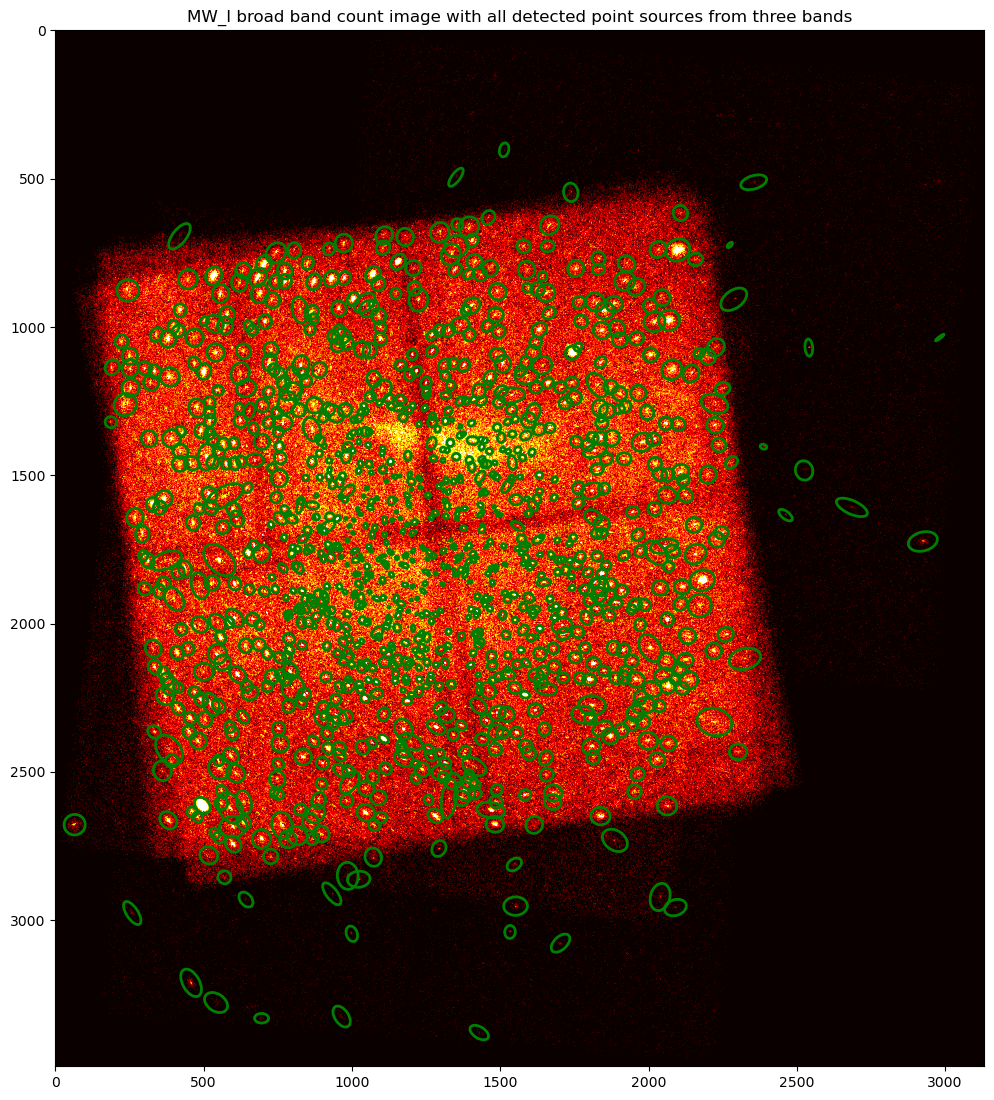

In [5]:
#priority: broad band > hard band > soft band 

s_src_reg_file= merged_dir+'band1_src_pnts.reg'
h_src_reg_file= merged_dir+'band2_src_pnts.reg'
b_src_reg_file= merged_dir+'band3_src_pnts.reg'

s_src_reg=rg.Regions.read(s_src_reg_file,format='ds9')
h_src_reg=rg.Regions.read(h_src_reg_file,format='ds9')
b_src_reg=rg.Regions.read(b_src_reg_file,format='ds9')

f = fits.open(s_count_img_merged)
wcs=WCS(f[0].header)

if verbose>=1: #tells number of sources found in each band
    print('detect '+str(len(s_src_reg))+' point sources from soft band image')
    print('detect '+str(len(h_src_reg))+' point sources from hard band image')
    print('detect '+str(len(b_src_reg))+' point sources from broad band image')

if verbose>=2: #i think this plots the same thing as ds9
    a=fits.open(s_count_img_merged)
    plt.figure(figsize=np.array(a[0].data.shape)/a[0].data.shape[0]*15)
    plt.imshow(np.log10(a[0].data+1),cmap='hot',vmin=0,\
           vmax=np.log10( (a[0].data.reshape(-1).mean()+1)*2 ))
    plt.title(target_name+' soft band count image with its detected point sources')
    for b in s_src_reg:
        b.to_pixel(wcs).plot( facecolor='none',edgecolor='green', lw=1)
        
    a=fits.open(h_count_img_merged)
    plt.figure(figsize=np.array(a[0].data.shape)/a[0].data.shape[0]*15)
    plt.imshow(np.log10(a[0].data+1),cmap='hot',vmin=0,\
           vmax=np.log10( (a[0].data.reshape(-1).mean()+1)*2 ))
    plt.title(target_name+' hard band count image with its detected point sources')
    for b in h_src_reg:
        b.to_pixel(wcs).plot( facecolor='none',edgecolor='green', lw=1)
        
    a=fits.open(b_count_img_merged)
    plt.figure(figsize=np.array(a[0].data.shape)/a[0].data.shape[0]*15)
    plt.imshow(np.log10(a[0].data+1),cmap='hot',vmin=0,\
           vmax=np.log10( (a[0].data.reshape(-1).mean()+1)*2 ))
    plt.title(target_name+' broad band count image with its detected point sources')
    for b in b_src_reg:
        b.to_pixel(wcs).plot( facecolor='none',edgecolor='green', lw=1)
        
        
merge_src_reg=copy.deepcopy(b_src_reg)


for pnt_src in h_src_reg: #checks hard band sources: adds sources not found already in the broad band to merged source list
    inflag=False
    for pnt_src2 in merge_src_reg:        
        if pnt_src2.contains(pnt_src.center,wcs):
            inflag=True
            break
    if inflag==False:
        merge_src_reg.append(pnt_src)
        
for pnt_src in s_src_reg: #checks soft band sources: adds sources not found already in the broad band to merged source list
    inflag=False
    for pnt_src2 in merge_src_reg:        
        if pnt_src2.contains(pnt_src.center,wcs):
            inflag=True
            break
    if inflag==False:
        merge_src_reg.append(pnt_src)
        
merge_src_reg_file=merged_dir+'merge_src_pnts.reg'
merge_src_reg.write(merge_src_reg_file, overwrite=True,format='ds9')

if verbose>=1: #tells total num of source points 
    print('merged into '+str(len(merge_src_reg))+' point sources')
    
    a=fits.open(b_count_img_merged) #plots the merged source points
    plt.figure(figsize=np.array(a[0].data.shape)/a[0].data.shape[0]*15)
    plt.imshow(np.log10(a[0].data+1),cmap='hot',vmin=0,\
           vmax=np.log10( (a[0].data.reshape(-1).mean()+1)*2 ))
    plt.title(target_name+' broad band count image with all detected point sources from three bands')
    for b in merge_src_reg:
        b.to_pixel(wcs).plot( facecolor='none',edgecolor='green', lw=2)
        
        
# #now back to CIAO format file
# d=ds9.DS9()
# d.set('file '+s_count_img_merged)
# d.set('regions '+merge_src_reg_file)
# d.set('regions format CIAO')
# d.set('regions system physical')
# d.set('regions save '+merge_src_reg_file)
# d.set('exit')

## Now create poisson-filled images with no sources

In [12]:
'''create background region by roi'''

#roi requires a fit file region

merge_src_fits_file=merged_dir+'merge_src_pnts.fits'
dmmakereg.punlearn()
dmmakereg(region='region('+merge_src_reg_file+')',outfile=merge_src_fits_file,wcsfile=b_count_img_merged,clobber=True)

#create background region by roi
source_reg_dir=merged_dir+'sources/'
try:
    os.mkdir(source_reg_dir)
except:
    for files in os.listdir(source_reg_dir):
        os.remove(source_reg_dir+files)        
    os.rmdir(source_reg_dir)
    os.mkdir(source_reg_dir)
    
roi.punlearn()
roi(infile=merge_src_fits_file,outsrcfile=source_reg_dir+'src%d.fits',bkgfactor=0.5,radiusmode='mul',bkgradius=2,group='exclude',clobber=True)
call(['splitroi',source_reg_dir+'src*.fits',source_reg_dir+'exclude'])

0

Set MJD-END to 54682.373229 from DATE-END'. [astropy.wcs.wcs]


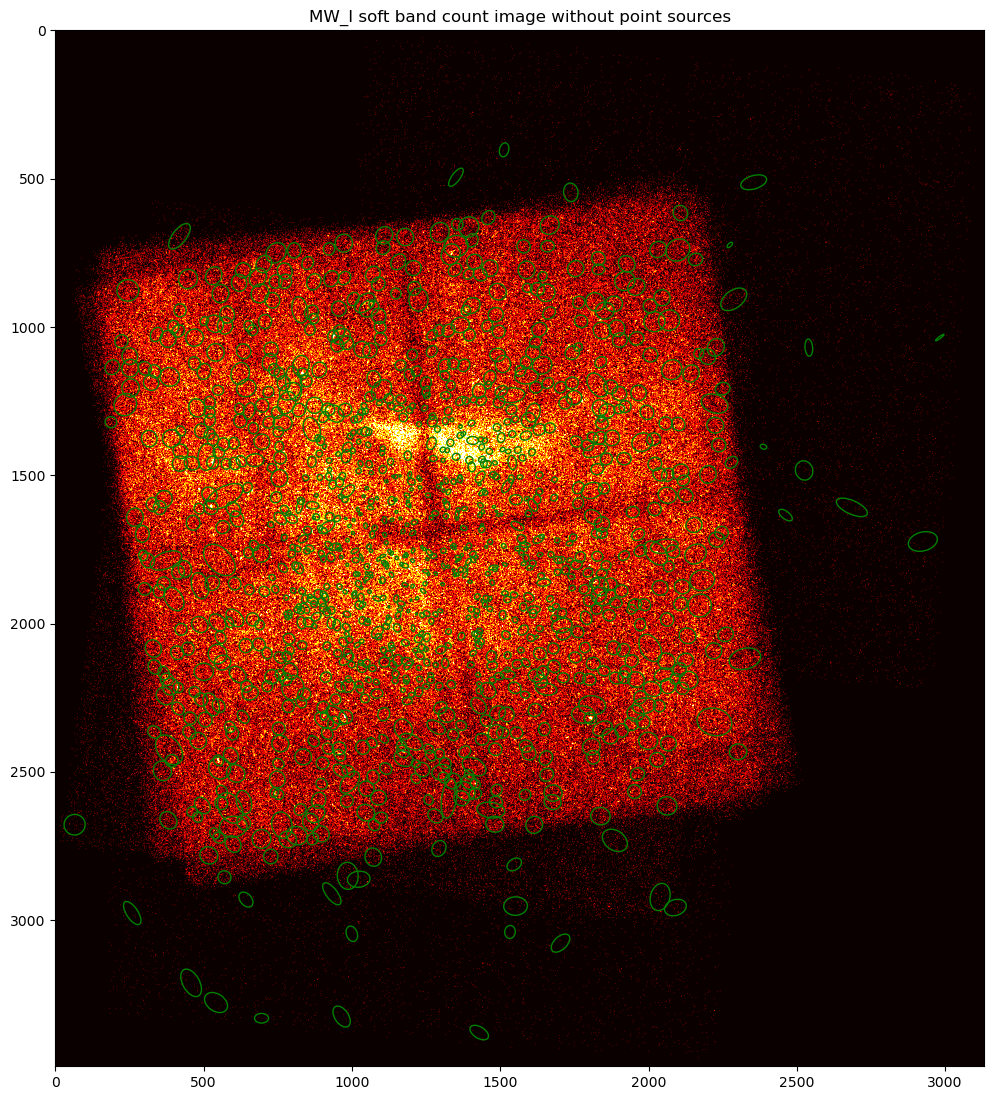

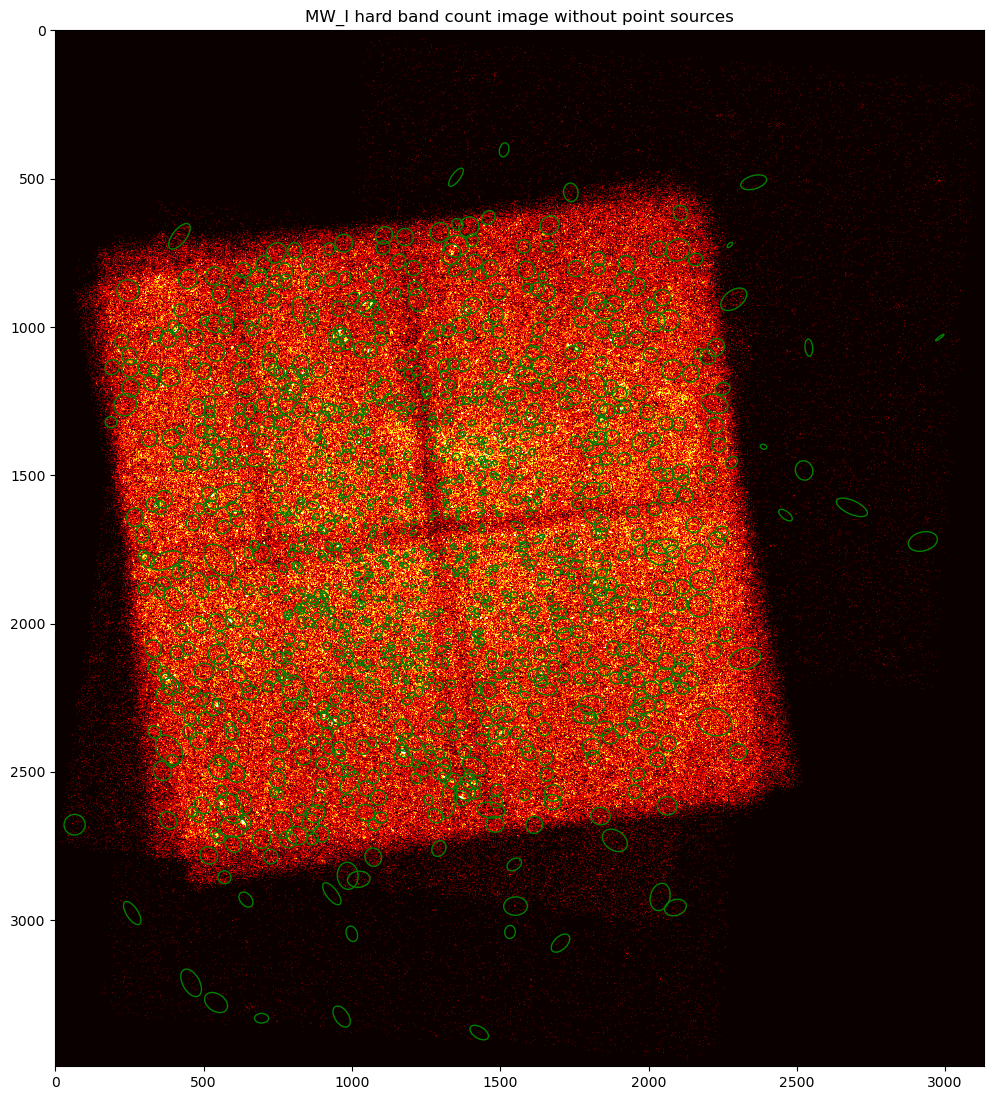

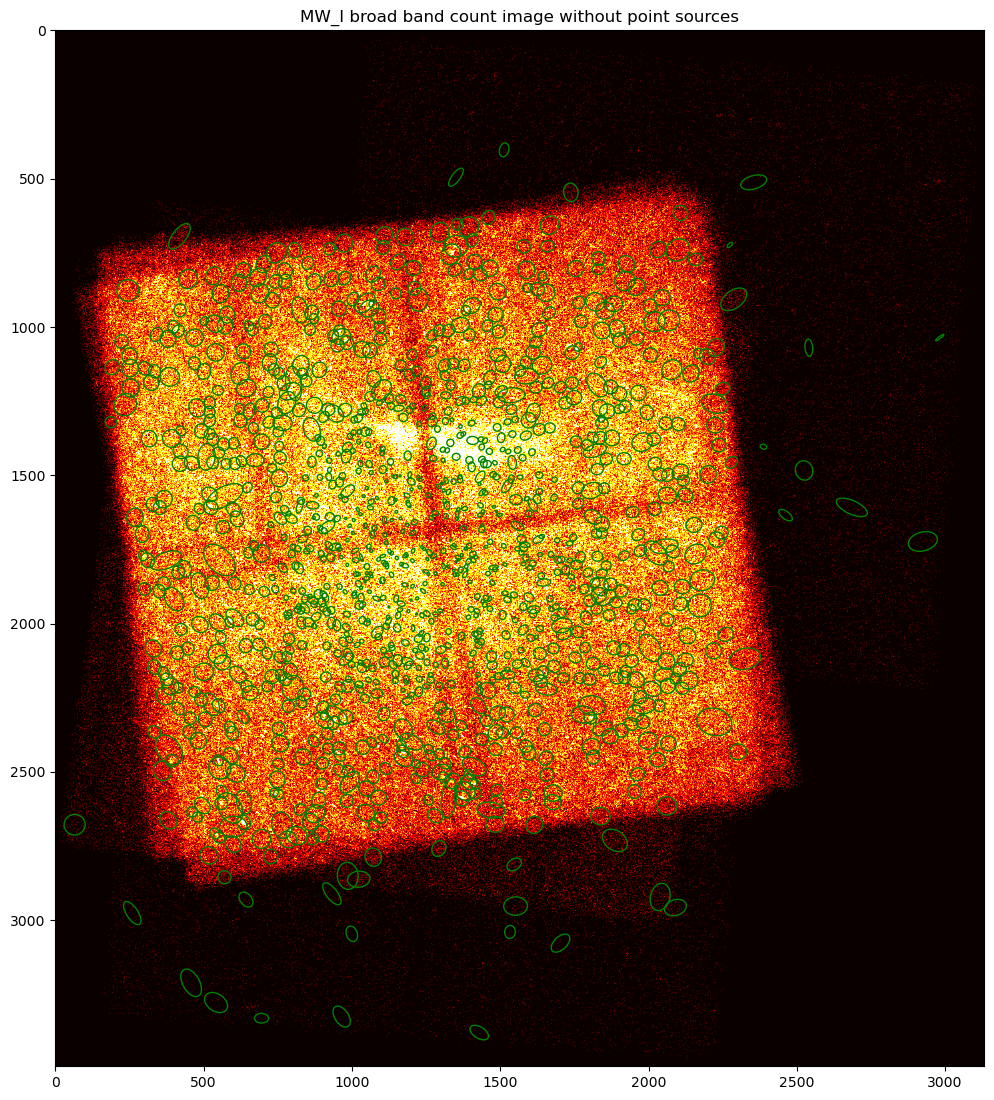

In [14]:
'''fill the hole with Poisson method'''


merge_src_file=merged_dir+'merge_src_pnts.reg'
merge_src_fits_file=merged_dir+'merge_src_pnts.fits'

dmfilth.punlearn()
s_filled_count_img=merged_dir+'band1_thresh_filled.img'
h_filled_count_img=merged_dir+'band2_thresh_filled.img'
b_filled_count_img=merged_dir+'band3_thresh_filled.img'

# I've already run the following functions - uncomment for new data set
dmfilth(infile=s_count_img_merged,outfile=s_filled_count_img,method='POISSON',randseed=0,\
        srclist='@'+source_reg_dir+'exclude.src.reg', bkglist='@'+source_reg_dir+'exclude.bg.reg',clobber=True)
dmfilth(infile=h_count_img_merged,outfile=h_filled_count_img,method='POISSON',randseed=0,\
        srclist='@'+source_reg_dir+'exclude.src.reg', bkglist='@'+source_reg_dir+'exclude.bg.reg',clobber=True)
dmfilth(infile=b_count_img_merged,outfile=b_filled_count_img,method='POISSON',randseed=0,\
        srclist='@'+source_reg_dir+'exclude.src.reg', bkglist='@'+source_reg_dir+'exclude.bg.reg',clobber=True)


merge_src_reg=rg.Regions.read(merge_src_file,format='ds9')
if verbose>=2:
    a=fits.open(s_filled_count_img)
    wcs=WCS(a[0].header)
    plt.figure(figsize=np.array(a[0].data.shape)/a[0].data.shape[0]*15)
    plt.imshow(np.log10(a[0].data+1),cmap='hot',vmin=0,\
           vmax=np.log10( (a[0].data.reshape(-1).mean()+1)*1.5 ))
    plt.title(target_name+' soft band count image without point sources')
    for b in merge_src_reg:
        b.to_pixel(wcs).plot( facecolor='none',edgecolor='green', lw=1)
    
    a=fits.open(h_filled_count_img)
    wcs=WCS(a[0].header)
    plt.figure(figsize=np.array(a[0].data.shape)/a[0].data.shape[0]*15)
    plt.imshow(np.log10(a[0].data+1),cmap='hot',vmin=0,\
           vmax=np.log10( (a[0].data.reshape(-1).mean()+1)*1.5 ))
    plt.title(target_name+' hard band count image without point sources')
    for b in merge_src_reg:
        b.to_pixel(wcs).plot( facecolor='none',edgecolor='green', lw=1)
        
if verbose>=1:
    a=fits.open(b_filled_count_img)
    wcs=WCS(a[0].header)
    plt.figure(figsize=np.array(a[0].data.shape)/a[0].data.shape[0]*15)
    plt.imshow(np.log10(a[0].data+1),cmap='hot',vmin=0,\
           vmax=np.log10( (a[0].data.reshape(-1).mean()+1)*1.5 ))
    plt.title(target_name+' broad band count image without point sources')
    for b in merge_src_reg:
        b.to_pixel(wcs).plot( facecolor='none',edgecolor='green', lw=1)

## Make blanksky 

In [4]:
'''write a minus region file for all point sources.'''

# Make sure it is in CIAO-Physical format first in DS9

merge_src_reg_file=merged_dir+'merge_src_pnts.reg'
pnt_src=np.loadtxt(merge_src_reg_file,dtype='<100U')
minus_pnt_src=np.zeros(len(pnt_src),dtype='<100U')
for i in range(len(pnt_src)):
    minus_pnt_src[i]=str('-'+pnt_src[i])
np.savetxt(merged_dir+'minus_merge_src_pnts.reg',minus_pnt_src,fmt='%s')


In [14]:
'''make blanksky files for each observation using the original events file'''

full_path = []
file_name = []

# Find the reproj_evt.fits files from the Merged folder
for root, dirs, files in os.walk(target_dir): 
    for file in files:
        if file.endswith('reproj_evt.fits'):
            full_path.append(os.path.join(root, file))
            file_name.append(file)

# Move the files back into their repro folders so they blanksky can find them
for file in full_path: 
    for obs in obsid:
         if obs in file:
            dest_dir = target_dir+obs+'/repro/'
            call(['mv', file, dest_dir])

# Run blanksky
for root, dirs, files in os.walk(target_dir):
    for file in files:
        if file.endswith('reproj_evt.fits'):
            os.chdir(root)
            
            file_part = file.split('_')[0]

            blanksky.punlearn()
            blanksky(evtfile=file,outfile=root+'/'+file_part+'_blanksky.fits',clobber=True)


## Spectrum Extraction

In [4]:
'''extract unresolved spectra for each observation's event file'''

reproj_evt_files = []
blanksky_files = []

for root, dirs, files in os.walk(target_dir): 
    for file in files:
        if file.endswith('reproj_evt.fits'):
            reproj_evt_files.append(os.path.join(root, file))
        elif file.endswith('blanksky.fits'):
            blanksky_files.append(os.path.join(root, file))
    
regfile = merged_dir+'specextract.reg'

for evt_file, bkg_file in zip(reproj_evt_files, blanksky_files):
    obs_id = os.path.basename(os.path.dirname(os.path.dirname(evt_file)))
    outroot = os.path.join(spec_dir, obs_id)

    specextract.punlearn()
    specextract(infile=f"{evt_file}[sky=region({regfile})]",outroot=f"{outroot}"\
                ,bkgfile=f"{bkg_file}[sky=region({regfile})]",verbose=1,bkgresp=False,combine=False,clobber=True)

    print(f"Done with spectrum extraction for {obs_id}")


Done with spectrum extraction for 5934
Done with spectrum extraction for 6362
Done with spectrum extraction for 6365
Done with spectrum extraction for 7162
Done with spectrum extraction for 7168
Done with spectrum extraction for 9500
Done with spectrum extraction for 9501
Done with spectrum extraction for 9502
Done with spectrum extraction for 9503
Done with spectrum extraction for 9504
Done with spectrum extraction for 9505
Done with spectrum extraction for 9854
Done with spectrum extraction for 9855
Done with spectrum extraction for 9892
Done with spectrum extraction for 9893


In [30]:
'''combine source-removed spectra from each event file/observation'''

spectra = []
bkg_spectra = []

# Look for all relevant spectrum files
spec_files = glob.glob(os.path.join(spec_dir, f'*.pi'))
pi_files = [f for f in spec_files if not f.endswith('_grp.pi')]

# Append them to a list
for file in pi_files:
    if file.endswith('bkg.pi'):
        bkg_spectra.append(file)
    else: 
        spectra.append(file)

# Print found spectra for verification
print("\nFound source spectra:", *spectra, sep='\n')
print("\nFound background spectra:", *bkg_spectra, sep='\n')

# Join the list entries into one string
spec_str = ','.join(spectra)
bkg_str = ','.join(bkg_spectra)

#Combine individual spectra into one
combine_spectra.punlearn()
combine_spectra(src_spectra=spec_str,bkg_spectra=bkg_str,outroot=spec_dir+'combined_spectrum')




Found source spectra:
/Volumes/backitup/MW_I/Spec/5934.pi
/Volumes/backitup/MW_I/Spec/6362.pi
/Volumes/backitup/MW_I/Spec/6365.pi
/Volumes/backitup/MW_I/Spec/7162.pi
/Volumes/backitup/MW_I/Spec/7168.pi
/Volumes/backitup/MW_I/Spec/9500.pi
/Volumes/backitup/MW_I/Spec/9501.pi
/Volumes/backitup/MW_I/Spec/9502.pi
/Volumes/backitup/MW_I/Spec/9503.pi
/Volumes/backitup/MW_I/Spec/9504.pi
/Volumes/backitup/MW_I/Spec/9505.pi
/Volumes/backitup/MW_I/Spec/9854.pi
/Volumes/backitup/MW_I/Spec/9855.pi
/Volumes/backitup/MW_I/Spec/9892.pi
/Volumes/backitup/MW_I/Spec/9893.pi

Found background spectra:
/Volumes/backitup/MW_I/Spec/5934_bkg.pi
/Volumes/backitup/MW_I/Spec/6362_bkg.pi
/Volumes/backitup/MW_I/Spec/6365_bkg.pi
/Volumes/backitup/MW_I/Spec/7162_bkg.pi
/Volumes/backitup/MW_I/Spec/7168_bkg.pi
/Volumes/backitup/MW_I/Spec/9500_bkg.pi
/Volumes/backitup/MW_I/Spec/9501_bkg.pi
/Volumes/backitup/MW_I/Spec/9502_bkg.pi
/Volumes/backitup/MW_I/Spec/9503_bkg.pi
/Volumes/backitup/MW_I/Spec/9504_bkg.pi
/Volumes/b

Prepared to combine 15 spectra

source PHA: /Volumes/backitup/MW_I/Spec/5934.pi
       ARF: /Volumes/backitup/MW_I/Spec/5934.arf
       RMF: /Volumes/backitup/MW_I/Spec/5934.rmf
    background PHA: /Volumes/backitup/MW_I/Spec/5934_bkg.pi
               ARF: None
               RMF: None
source PHA: /Volumes/backitup/MW_I/Spec/6362.pi
       ARF: /Volumes/backitup/MW_I/Spec/6362.arf
       RMF: /Volumes/backitup/MW_I/Spec/6362.rmf
    background PHA: /Volumes/backitup/MW_I/Spec/6362_bkg.pi
               ARF: None
               RMF: None
source PHA: /Volumes/backitup/MW_I/Spec/6365.pi
       ARF: /Volumes/backitup/MW_I/Spec/6365.arf
       RMF: /Volumes/backitup/MW_I/Spec/6365.rmf
    background PHA: /Volumes/backitup/MW_I/Spec/6365_bkg.pi
               ARF: None
               RMF: None
source PHA: /Volumes/backitup/MW_I/Spec/7162.pi
       ARF: /Volumes/backitup/MW_I/Spec/7162.arf
       RMF: /Volumes/backitup/MW_I/Spec/7162.rmf
    background PHA: /Volumes/backitup/MW_I/Spec/7162_b

In [5]:
'''extract detected source spectra for each observation's event file'''

reproj_evt_files = []
blanksky_files = []

for root, dirs, files in os.walk(target_dir): 
    for file in files:
        if file.endswith('reproj_evt.fits'):
            reproj_evt_files.append(os.path.join(root, file))
        elif file.endswith('blanksky.fits'):
            blanksky_files.append(os.path.join(root, file))
    
regfile = merged_dir+'halo.reg'

for evt_file, bkg_file in zip(reproj_evt_files, blanksky_files):
    obs_id = os.path.basename(os.path.dirname(os.path.dirname(evt_file)))
    outroot = os.path.join(spec2_dir, obs_id)

    specextract.punlearn()
    specextract(infile=f"{evt_file}[sky=region({regfile})]",outroot=f"{outroot}"\
                ,bkgfile=f"{bkg_file}[sky=region({regfile})]",verbose=1,bkgresp=False,combine=False,clobber=True)

    print(f"Done with spectrum extraction for {obs_id}")


Done with spectrum extraction for 5934
Done with spectrum extraction for 6362
Done with spectrum extraction for 6365
Done with spectrum extraction for 7162
Done with spectrum extraction for 7168
Done with spectrum extraction for 9500
Done with spectrum extraction for 9501
Done with spectrum extraction for 9502
Done with spectrum extraction for 9503
Done with spectrum extraction for 9504
Done with spectrum extraction for 9505
Done with spectrum extraction for 9854
Done with spectrum extraction for 9855
Done with spectrum extraction for 9892
Done with spectrum extraction for 9893


In [3]:
'''combine source-included spectra from each event file/observation'''

spectra = []
bkg_spectra = []

# Look for all relevant spectrum files
spec_files = glob.glob(os.path.join(spec2_dir, f'*.pi'))
pi_files = [f for f in spec_files if not f.endswith('_grp.pi')]

# Append them to a list
for file in pi_files:
    if file.endswith('bkg.pi'):
        bkg_spectra.append(file)
    else: 
        spectra.append(file)

# Print found spectra for verification
print("\nFound source spectra:", *spectra, sep='\n')
print("\nFound background spectra:", *bkg_spectra, sep='\n')

# Join the list entries into one string
spec_str = ','.join(spectra)
bkg_str = ','.join(bkg_spectra)

#Combine individual spectra into one
combine_spectra.punlearn()
combine_spectra(src_spectra=spec_str,bkg_spectra=bkg_str,outroot=spec2_dir+'combined_spectrum')




Found source spectra:
/Volumes/backitup/MW_I/Spec2/5934.pi
/Volumes/backitup/MW_I/Spec2/6362.pi
/Volumes/backitup/MW_I/Spec2/6365.pi
/Volumes/backitup/MW_I/Spec2/7162.pi
/Volumes/backitup/MW_I/Spec2/7168.pi
/Volumes/backitup/MW_I/Spec2/9500.pi
/Volumes/backitup/MW_I/Spec2/9501.pi
/Volumes/backitup/MW_I/Spec2/9502.pi
/Volumes/backitup/MW_I/Spec2/9503.pi
/Volumes/backitup/MW_I/Spec2/9504.pi
/Volumes/backitup/MW_I/Spec2/9505.pi
/Volumes/backitup/MW_I/Spec2/9854.pi
/Volumes/backitup/MW_I/Spec2/9855.pi
/Volumes/backitup/MW_I/Spec2/9892.pi
/Volumes/backitup/MW_I/Spec2/9893.pi

Found background spectra:
/Volumes/backitup/MW_I/Spec2/5934_bkg.pi
/Volumes/backitup/MW_I/Spec2/6362_bkg.pi
/Volumes/backitup/MW_I/Spec2/6365_bkg.pi
/Volumes/backitup/MW_I/Spec2/7162_bkg.pi
/Volumes/backitup/MW_I/Spec2/7168_bkg.pi
/Volumes/backitup/MW_I/Spec2/9500_bkg.pi
/Volumes/backitup/MW_I/Spec2/9501_bkg.pi
/Volumes/backitup/MW_I/Spec2/9502_bkg.pi
/Volumes/backitup/MW_I/Spec2/9503_bkg.pi
/Volumes/backitup/MW_I/Spe

Prepared to combine 15 spectra

source PHA: /Volumes/backitup/MW_I/Spec2/5934.pi
       ARF: /Volumes/backitup/MW_I/Spec2/5934.arf
       RMF: /Volumes/backitup/MW_I/Spec2/5934.rmf
    background PHA: /Volumes/backitup/MW_I/Spec2/5934_bkg.pi
               ARF: None
               RMF: None
source PHA: /Volumes/backitup/MW_I/Spec2/6362.pi
       ARF: /Volumes/backitup/MW_I/Spec2/6362.arf
       RMF: /Volumes/backitup/MW_I/Spec2/6362.rmf
    background PHA: /Volumes/backitup/MW_I/Spec2/6362_bkg.pi
               ARF: None
               RMF: None
source PHA: /Volumes/backitup/MW_I/Spec2/6365.pi
       ARF: /Volumes/backitup/MW_I/Spec2/6365.arf
       RMF: /Volumes/backitup/MW_I/Spec2/6365.rmf
    background PHA: /Volumes/backitup/MW_I/Spec2/6365_bkg.pi
               ARF: None
               RMF: None
source PHA: /Volumes/backitup/MW_I/Spec2/7162.pi
       ARF: /Volumes/backitup/MW_I/Spec2/7162.arf
       RMF: /Volumes/backitup/MW_I/Spec2/7162.rmf
    background PHA: /Volumes/backitup/M

## Plot!

read ARF file /Volumes/backitup/MW_I/Spec/combined_spectrum_src.arf
read RMF file /Volumes/backitup/MW_I/Spec/combined_spectrum_src.rmf
read background file /Volumes/backitup/MW_I/Spec/combined_spectrum_bkg.pi
dataset 1: 0.0073:14.9504 -> 0.292:8.0008 Energy (keV)
read ARF file /Volumes/backitup/MW_I/Spec2/combined_spectrum_src.arf
read RMF file /Volumes/backitup/MW_I/Spec2/combined_spectrum_src.rmf
read background file /Volumes/backitup/MW_I/Spec2/combined_spectrum_bkg.pi
dataset 2: 0.0073:14.9504 -> 0.292:8.0008 Energy (keV)


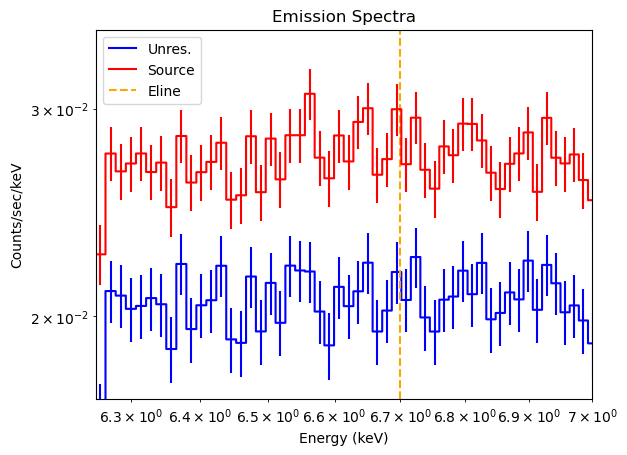

In [21]:
'''check spectrum'''

# os.chdir(target_dir)

unresolved_spectrum = spec_dir+'combined_spectrum_src.pi'
unresolved_background = spec_dir+'combined_spectrum_bkg.pi'

source_spectrum = spec2_dir+'combined_spectrum_src.pi'
source_background = spec2_dir+'combined_spectrum_bkg.pi'

load_pha(1,unresolved_spectrum)
notice_id(1,0.3,8.0)
subtract(1)

load_pha(2,source_spectrum)
notice_id(2,0.3,8.0)
subtract(2)

plot_data(1,xlog=True,ylog=True,linestyle="-",marker="none",color="blue",label='Unres.')
# plot_bkg(1,xlog=True,ylog=True,linestyle="-", marker="none",color="gray",overplot=True,label='Unres. Bkg')

plot_data(2,xlog=True,ylog=True,linestyle="-",marker="none",color="red",label='Source',overplot=True)
# plot_bkg(2,xlog=True,ylog=True,linestyle="-", marker="none",color="black",overplot=True,label='Source')

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%g"))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%g"))
plt.axvline(x=6.7, color='orange', linestyle='--',label='Eline')
# plt.xlim(6.25,7.0)
# plt.ylim(0.017,0.035)
plt.title('Emission Spectra')
plt.legend(loc="upper left")
plt.show()



In [16]:
''' The increasing component past 6 keV is due to the AREASCAL =/= 1'''

#setting areascal back to 1
unresolved_spectrum = spec_dir+'combined_spectrum_src.pi'
unresolved_background = spec_dir+'combined_spectrum_bkg.pi'

source_spectrum = spec2_dir+'combined_spectrum_src.pi'
source_background = spec2_dir+'combined_spectrum_bkg.pi'

a=fits.open(unresolved_background)
a[1].header['AREASCAL'] = 1
a.writeto(unresolved_background,overwrite=True)

b=fits.open(source_background)
b[1].header['AREASCAL'] = 1
b.writeto(source_background,overwrite=True)